author: Mabel Calim Costa

27/02/2022

## ZCAS example

OLR - [NOAA Interpolated OLR](https://psl.noaa.gov/cgi-bin/db_search/DBSearch.pl?Dataset=NOAA+Interpolated+OLR&Variable=Outgoing+Longwave+Radiation)
CHIRPS - [ainfall Estimates from Rain Gauge and Satellite OBS](https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_monthly/)

data (jan-dez 2021)
averaged area (25S 23S 55W 46W) Sao Paulo State area

In [10]:
import numpy as np
from numpy import ma
from matplotlib import pyplot as plt
import scipy.stats as stats
from IPython.display import display, Math, Latex
from numpy.random import rand
from netCDF4 import Dataset
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%pylab inline




Populating the interactive namespace from numpy and matplotlib


In [5]:
def open_data(path):
    f = Dataset(path)
    nc = f.variables
    return nc

path = 'Your path'
#nc = open_data('OLR_NCAR_1981_2010_month.nc')
#time = nc['time']
#OLR_1981_2010 = nc['olr'][:].mean(axis=1).mean(axis=1)
#OLR_1981_2010

#OLR_clim = (nc['olr'][0:(len(nc['olr'])-(365*11))]).mean(axis=1).mean(axis=1)
#OLR = nc['olr'][:].mean(axis=1).mean(axis=1)


nc1 = open_data(path+'data/OLR_2021_55W46W25S23S.nc')
OLR_2021 = (nc1['olr'][:]).mean(axis=1).mean(axis=1)
#OLR_clim = (nc1['olr'][0:(len(nc1['olr'])-(365*11))]).mean(axis=1).mean(axis=1)

nc = open_data(path+'data/chirps-v2.0.2021.days_p25.nc')
lon = nc['longitude'][:]
ind = lon<=0
#lon[ind] = lon[ind]+360
#lon = np.concatenate((lon[~ind],lon[ind]),axis =0)
lat = nc['latitude'][:]
lon_min= np.abs(lon[:] -(-55)).argmin() #-62
lon_max= np.abs(lon[:] -(-46)).argmin() #-52
lat_min= np.abs(nc['latitude'][:] -(-25)).argmin() #-22
lat_max= np.abs(nc['latitude'][:] -(-23)).argmin() #-12
prec = ma.masked_values(nc['precip'][:,lat_min:lat_max,lon_min:lon_max],nc['precip'].missing_value)
#prec = nc['precip'][:,lat_min:lat_max,lon_min:lon_max]

prec_2021 = ma.mean(ma.mean(prec[:], axis=1),axis=1)

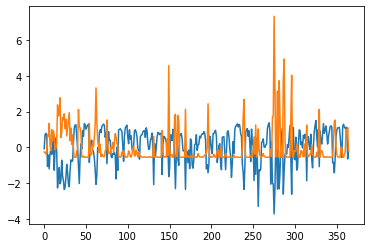

In [6]:
def normalize(data):
    """
    NORMALIZE FUNCTION by - mean/sqrt(variance)
    """
    variance = np.var(data)
    data = (data - np.mean(data)) / (np.sqrt(variance))
    return data

OLR_2021_norm = normalize(OLR_2021)
prec_2021_norm = normalize(prec_2021)
plot(OLR_2021_norm)
plot(prec_2021_norm)

In [7]:
def lanczos (data,f_low,f_up):
        """ LANCZOS FILTER
            ______________________________________________
            Input: n    - number of weight    
                   m    - number of test frequencies    
                   f_up - upper frequency       
                   f_low- lower frequency       
                    
            Output:weight - weight vector to convolve
                   R      - response curve of the filter
            -----------------------------------------------
                if m = 0 no test is performed 
        """
        n = len(data)
        m = n
        fc = (f_up +f_low) /2                                   # Lanczos cut frequency
        # weight function
        fc = (fc * 360/(n)) * math.pi/180                                   # in radians
        wl0=fc/pi                                               # frequency 0     
        wl = []                                                 # create a list of weights 
        for i in range(1,n+1):
                wl.append(n/pow((i*pi),2)* sin(fc*i)*sin(i*pi/n))       # smooth filter curve
        # simetric weight function
        wl.insert(0,wl0)
        weight = np.concatenate((wl[::-1],wl), axis=0)
        #print sum(weight)                                      # sum must be = 1
        # testing filter
        omega = [j*(pi/180) for j in range(1,m+1)]              # test frequencies in radians
        omega.insert(0,0)                                       # insert zero in zero position
        R,sum = ma.masked_all(m+1),ma.masked_all(m+1)
        if (m!=0):
        # BAD for m>400
          for j in range(1,m+1):
              soma = 0
              for i in range(1,n+1):
                  soma += (wl[i]*cos(i*omega[j]))
              R[j] = wl0 + (2*soma)
            
        # convolve data
        data_filt = np.convolve(weight,data, mode='full')
        data_filt = data_filt[len(R):len(data_filt)-len(R)+1]
        return data_filt
prec_2021_filt = lanczos(prec_2021_norm,30,90)
OLR_2021_filt = lanczos(OLR_2021_norm,30,90)

Text(0.5, 0.9, '2021 \n OLR and PREC normalized (-mean/std) \n filtered (lanczos) 30 -90 days \n averaged area 45W 35W 15S 10S ')

([], [])

Text(0.5, 0, 'days')

([<matplotlib.axis.XTick at 0x11a8ac910>,
 [Text(0, 0, 'JAN'),
  Text(31, 0, 'FEB'),
  Text(59, 0, 'MAR'),
  Text(90, 0, 'APR'),
  Text(120, 0, 'MAY'),
  Text(151, 0, 'JUN'),
  Text(181, 0, 'JUL'),
  Text(212, 0, 'AUG'),
  Text(243, 0, 'SEP'),
  Text(273, 0, 'OCT'),
  Text(304, 0, 'NOV'),
  Text(334, 0, 'DEC')])

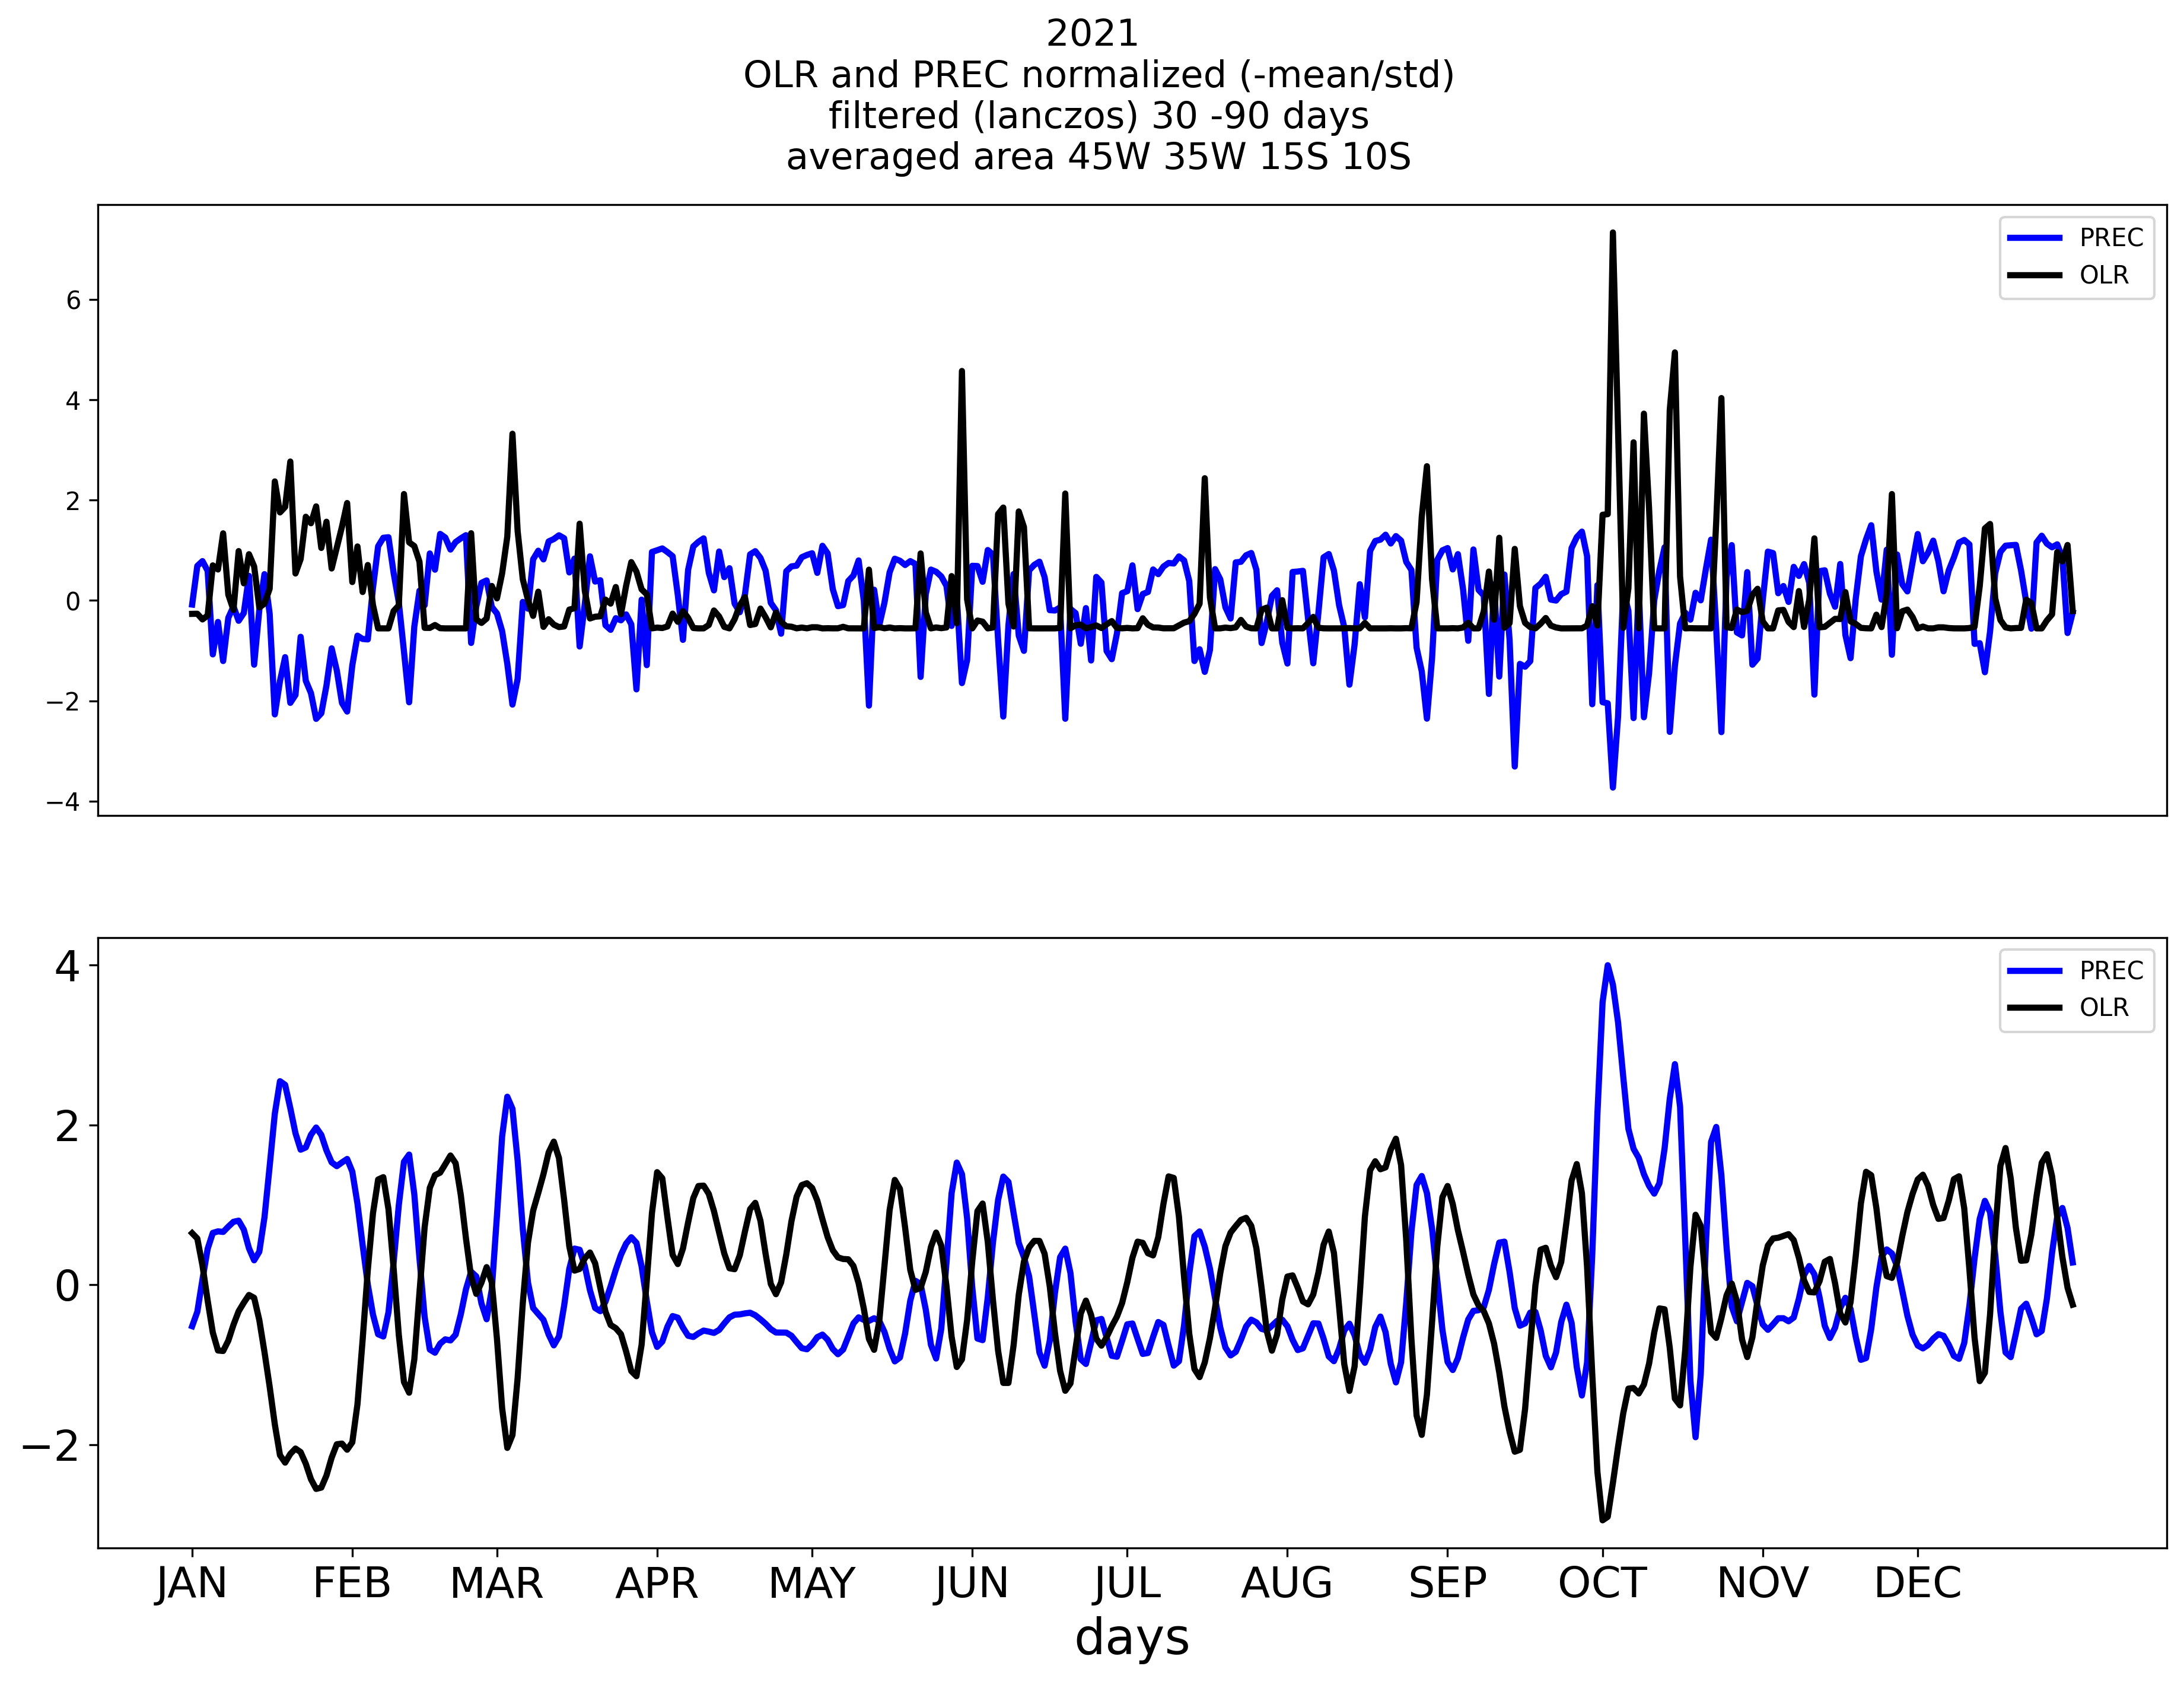

In [13]:
fig = plt.figure(figsize=(15,10), dpi=300)
fig.text(.5, .9, '2021 \n OLR and PREC normalized (-mean/std) \n filtered (lanczos) 30 -90 days \n averaged area 45W 35W 15S 10S ', horizontalalignment='center',fontsize=15)

ax = subplot(2,1,1)
ax.plot(OLR_2021_norm,'b',linewidth=2.5, label='PREC')
ax.plot(prec_2021_norm,'k',linewidth=2.5, label='OLR')
ax.legend()
xticks([])
ax = subplot(2,1,2)
ax.plot(prec_2021_filt,'b',linewidth=2.5, label='PREC')

ax.plot(OLR_2021_filt,'k',linewidth=2.5, label='OLR')
ax.set_xlabel('days',fontsize=20)
#ax.set_ylabel('months',fontsize=20)
xticks([0,31,59,90,120,151,181,212,243,273,304,334], ['JAN', 'FEB', 'MAR','APR','MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT','NOV','DEC']) 

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.yaxis.set_tick_params(labelsize='xx-large')
ax.xaxis.set_tick_params(labelsize='xx-large')
ax.legend()
#rect = fig.patch
#rect.set_facecolor("white")
plt.savefig(path+'figs/OLR_PREC_2021_ts.png',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()